In [1]:
# Imports

import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import re
import json

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score 
from sklearn.preprocessing import LabelEncoder 

from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.callbacks import EarlyStopping

import tensorflow as tf
import tensorflow_addons as tfa

import seaborn as sn

from nltk.corpus import stopwords

import pickle

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

# BERT model, tokenizer
from tensorflow.python.keras.layers import Flatten

from transformers import TFBertForSequenceClassification, TFAutoModel , AutoTokenizer

In [2]:
# Constants

ITER = "1"

# Specialis karakterekkel a maximalis kodolt szoveg max hossza

SHUFFLE_RANDOM_STATE = 42
TRAIN_RANDOM_STATE = 42
TEST_RANDOM_STATE = 42

USE_STOPWORDS = True
LOAD_CHECKPOINT = False
CHECKPOINT_SUBDIR = 'sport/'
CHECKPOINT_PREFIX = 'restore_best_cased_stopwords_9/'

TEXT = 'Sentence'
START_TOKEN = 'START'
TOKEN_LEN = 'LEN'
Y_HEADER = 'LABEL'
LABELS = {
    "SPORT": 0,
    "VIDEÓJÁTÉK": 1
}

MAX_SEQUENCE_LENGTH = 64

BATCH_SIZE = 16
EPOCHS = 10
# Maximum hány dokumentumot nézzünk. None esetén mindet
TRAIN_PROCESSED_MAX_DOCUMENTS = None
# Maximum hány dokumentumot nézzünk. None esetén mindet
TEST_PROCESSED_MAX_DOCUMENTS = None

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
if physical_devices:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)

path = 'checkpoints/' + CHECKPOINT_SUBDIR + CHECKPOINT_PREFIX

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
URL_RE = 'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}([-a-zA-Z0-9()@:%_+.~#?&/=]*)'
WHITELIST_RE = '[^a-zA-Z0-9íÍöÖüÜóÓőŐúÚáÁéÉűŰ]'

ures = 0

def cleanse(i):
    global ures
    text = dataset[TEXT].iloc[i]
    text = re.sub(URL_RE, ' ', text)
    text = re.sub(WHITELIST_RE, ' ', text)
    text = ' '.join([text])
    return re.sub(' +', ' ', text)

def delete_empty_rows(dataset):
    ids_to_delete = dataset.index[dataset[TEXT] == ' '].tolist()
    return dataset.drop(ids_to_delete)

In [5]:
# Load and set up data


dataset = pd.read_csv('db/sport_or_e_sport.csv', sep=';', error_bad_lines=False)
dataset[Y_HEADER] = dataset[Y_HEADER].map(LABELS)
dataset = shuffle(dataset, random_state=SHUFFLE_RANDOM_STATE)
dataset.info()

dataset = delete_empty_rows(dataset)
for i  in range(len(dataset.index)):
    dataset[TEXT].iloc[i] = cleanse(i)
    
dataset = delete_empty_rows(dataset)
dataset.head(5)
X = dataset[TEXT].values
y = dataset[Y_HEADER].values

X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8, random_state=TRAIN_RANDOM_STATE)

X_dev, X_test, y_dev, y_test = train_test_split(X_rem, y_rem, train_size=0.5, random_state=TEST_RANDOM_STATE)

y_train_labels = y_train
y_dev_labels = y_dev
y_test_labels = y_test
y_train = to_categorical(y_train, 2)
y_dev = to_categorical(y_dev, 2)
y_test = to_categorical(y_test, 2)


C:\Users\Daniel_Janos_Robert\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3417: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 49954 entries, 7565 to 15795
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Sentence    49954 non-null  object
 1   LABEL       49954 non-null  int64 
 2   Unnamed: 2  1 non-null      object
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


C:\Users\Daniel_Janos_Robert\anaconda3\envs\vegleges_tf\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


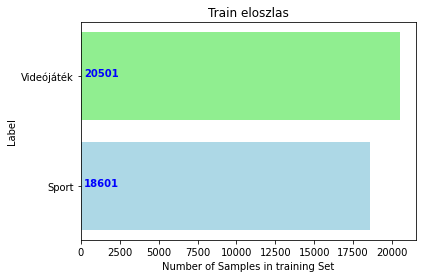

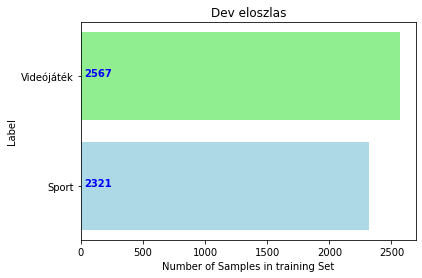

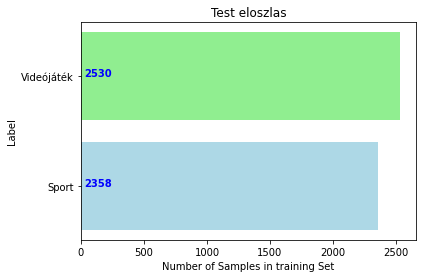

In [6]:
# eloszlas

def plot_label_counts(y, title='y labels'):
    unique, counts = np.unique(y, return_counts=True)
    b = dict(zip(unique, counts))
    plt.barh(range(len(b)),  list(b.values()), align='center', color=['lightblue', 'lightgreen'])
    y_values = ["Sport", "Videójáték"]
    y_axis = np.arange(0, 2, 1)
    plt.yticks(y_axis, y_values)
    plt.title(title)
    plt.xlabel('Number of Samples in training Set')
    plt.ylabel('Label')
    ax = plt.gca()
    for i, v in enumerate(b.values()):
        plt.text(ax.get_xlim()[1]/100, i, str(v), color='blue', fontweight='bold')
    plt.show()


plot_label_counts(y_train_labels, 'Train eloszlas')
plot_label_counts(y_dev_labels, 'Dev eloszlas')
plot_label_counts(y_test_labels, 'Test eloszlas')


In [7]:
bert_tokenizer = AutoTokenizer.from_pretrained("SZTAKI-HLT/hubert-base-cc")
bert_model = TFBertForSequenceClassification.from_pretrained("SZTAKI-HLT/hubert-base-cc", num_labels=2)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at SZTAKI-HLT/hubert-base-cc and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
all_stopwords = []

def apply_stopwords(sentences):
    global all_stopwords
    corpus = []
    for sen in sentences:
        sentence = sen.split()
        all_stopwords = stopwords.words('hungarian')
        whitelist = ["ne", "nem", "se", "sem"]
        sentence = [word for word in sentence if (word.lower() not in all_stopwords or word.lower() in whitelist)
                 and len(word) > 1]
        sentence = ' '.join(sentence)
        corpus.append(sentence)

    return corpus


In [9]:
def batch_encode(X):
    return bert_tokenizer.batch_encode_plus(
    X,
    truncation=True,
    max_length=MAX_SEQUENCE_LENGTH,
    add_special_tokens=True, # add [CLS] and [SEP] tokens
    return_attention_mask=True,
    return_token_type_ids=False, # not needed for this type of ML task
    padding='max_length', # add 0 pad tokens to the sequences less than max_length
    return_tensors='tf'
)
X_train = X_train.tolist() if not USE_STOPWORDS else apply_stopwords(X_train.tolist())
X_dev = X_dev.tolist() if not USE_STOPWORDS else apply_stopwords(X_dev.tolist())
X_test = X_test.tolist() if not USE_STOPWORDS else apply_stopwords(X_test.tolist())


X_train = batch_encode(X_train[:TRAIN_PROCESSED_MAX_DOCUMENTS])
X_dev = batch_encode(X_dev[:TEST_PROCESSED_MAX_DOCUMENTS])
X_test = batch_encode(X_test[:TEST_PROCESSED_MAX_DOCUMENTS])
y_train = y_train[:TRAIN_PROCESSED_MAX_DOCUMENTS]
y_dev = y_dev[:TEST_PROCESSED_MAX_DOCUMENTS]
y_test = y_test[:TEST_PROCESSED_MAX_DOCUMENTS]

In [10]:
def create_model():
    input_ids = tf.keras.layers.Input(shape=(64,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.layers.Input((64,), dtype=tf.int32, name='attention_mask')
    output = bert_model([input_ids, attention_mask])[0]
    output = tf.keras.layers.Dropout(rate=0.15)(output)
    output = tf.keras.layers.Dense(2, activation='softmax')(output)
    result = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output)
    return result

model = create_model()

opt = tf.keras.optimizers.Adam(learning_rate=3e-5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
print(bert_model.config)
model.summary()


BertConfig {
  "_name_or_path": "SZTAKI-HLT/hubert-base-cc",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32001
}

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 64)]         0                                            
________________________________________________________________________________

In [12]:
checkpoint_path = path + 'cp.ckpt'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [13]:
def get_history_as_text(history, epoch):
    return f'Epoch {epoch+1: <3}: loss: {format(history["loss"][epoch], ".4f")} - accuracy: {format(history["accuracy"][epoch], ".4f")} - val_loss: {format(history["val_loss"][epoch], ".4f")} - val_accuracy: {format(history["val_accuracy"][epoch], ".4f")}'

def fit_model():
    if not LOAD_CHECKPOINT:
        early_stopping_callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2, restore_best_weights=True)
        if ITER == "11":
            history = model.fit(
                x=X_train.values(),
                y=y_train,
                validation_data=(X_dev.values(), y_dev),
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                callbacks=[early_stopping_callback, cp_callback]
            )
        else:
            history = model.fit(
                x=X_train.values(),
                y=y_train,
                validation_data=(X_dev.values(), y_dev),
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                callbacks=[early_stopping_callback]
            )
        with open(path + '.history', 'wb') as file_pi:
            pickle.dump(history.history, file_pi)
        text_file = open(path + "history" + ITER + ".txt", "w")
        print(len(history.history['loss']))
        for i in range(len(history.history['loss'])):
            history_text = get_history_as_text(history.history, i)
            print(history_text)
            text_file.writelines(history_text + '\n')
        text_file.close()
    else:
        model.load_weights(checkpoint_path)
        history = pickle.load(open(path + '.history', "rb"))
        for i in range(len(history['loss'])):
            history_text = get_history_as_text(history, i)
            print(history_text)
    result = model.evaluate(X_test.values(), y_test)
    predict = model.predict(X_test.values())
    np_predict = np.argmax(predict,axis=1)
    return history, result, np_predict

In [14]:
#history, result, predict = fit_model()

In [15]:
le = LabelEncoder()

def evaluate(predict, result, y):
    y_le = le.fit_transform(y[:TEST_PROCESSED_MAX_DOCUMENTS])
    print('Classification report:')
    print(classification_report(y_le, predict))
    print(f'Accuracy: {accuracy_score(y_le, predict): >43}')
    print(f'Accuracy from evaluation: {result[1]: >27}')
    print('Confusion matrix:')
    df_cm = pd.DataFrame(confusion_matrix(y_le, predict),
                         index=[i for i in ['sport', 'videójáték']],
                         columns=[i for i in ['sport', 'videójáték']])
    if not LOAD_CHECKPOINT:
        with open(path + "results" + ITER + ".txt", "w") as text_file:
            df_cm_string = df_cm.to_string(header=False, index=False)
            text_file.write('Classification report:\n')
            text_file.write(classification_report(y_le, predict))
            text_file.write(f'\nAccuracy: {accuracy_score(y_le, predict): >43}\n')
            text_file.write(f'Accuracy from evaluation: {result[1]: >27}\n')
            text_file.write('\nConfusion matrix:\n')
            text_file.write(df_cm_string)
    plt.figure(figsize=(10,7))
    plt.title(CHECKPOINT_PREFIX[:-1])
    hm = sn.heatmap(df_cm, annot=True, fmt='g', cmap="Blues")
    hm.set(ylabel='True label', xlabel='Predicted label')
    if not LOAD_CHECKPOINT:
        plt.savefig(path + 'accuracy-' + format(result[1], ".4f") + ITER + '.jpg')
    plt.show()
    

In [16]:
le = LabelEncoder()

def evaluate(predict, result, y):
    y_le = le.fit_transform(y[:TEST_PROCESSED_MAX_DOCUMENTS])
    print('Classification report:')
    print(classification_report(y_le, predict))
    print(f'Accuracy: {accuracy_score(y_le, predict): >43}')
    print(f'Accuracy from evaluation: {result[1]: >27}')
    print('Confusion matrix:')
    df_cm = pd.DataFrame(confusion_matrix(y_le, predict),
                         index=[i for i in ['sport', 'videójáték']],
                         columns=[i for i in ['sport', 'videójáték']])
    if not LOAD_CHECKPOINT:
        with open(path + "results" + ITER + ".txt", "w") as text_file:
            df_cm_string = df_cm.to_string(header=False, index=False)
            text_file.write('Classification report:\n')
            text_file.write(classification_report(y_le, predict))
            text_file.write(f'\nAccuracy: {accuracy_score(y_le, predict): >43}\n')
            text_file.write(f'Accuracy from evaluation: {result[1]: >27}\n')
            text_file.write('\nConfusion matrix:\n')
            text_file.write(df_cm_string)
    plt.figure(figsize=(10,7))
    plt.title(CHECKPOINT_PREFIX[:-1])
    hm = sn.heatmap(df_cm, annot=True, fmt='g', cmap="Blues")
    hm.set(ylabel='True label', xlabel='Predicted label')
    if not LOAD_CHECKPOINT:
        plt.savefig(path + 'accuracy-' + format(result[1], ".4f") + ITER + '.jpg')
    plt.show()
    

Iteration  9
Epoch 1/10
2444/2444 [==============================] - 1820s 740ms/step - loss: 0.2067 - accuracy: 0.9090 - val_loss: 0.1911 - val_accuracy: 0.9182
Epoch 2/10
2444/2444 [==============================] - 1983s 812ms/step - loss: 0.1517 - accuracy: 0.9357 - val_loss: 0.1681 - val_accuracy: 0.9384
Epoch 3/10
2444/2444 [==============================] - 2014s 824ms/step - loss: 0.1150 - accuracy: 0.9516 - val_loss: 0.1632 - val_accuracy: 0.9358
Epoch 4/10
2444/2444 [==============================] - 2013s 824ms/step - loss: 0.1008 - accuracy: 0.9583 - val_loss: 0.2125 - val_accuracy: 0.9390
Epoch 5/10
2444/2444 [==============================] - 1960s 802ms/step - loss: 0.0867 - accuracy: 0.9652 - val_loss: 0.1926 - val_accuracy: 0.9372
Restoring model weights from the end of the best epoch.
Epoch 00005: early stopping
5
Epoch 1  : loss: 0.2067 - accuracy: 0.9090 - val_loss: 0.1911 - val_accuracy: 0.9182
Epoch 2  : loss: 0.1517 - accuracy: 0.9357 - val_loss: 0.1681 - val_acc

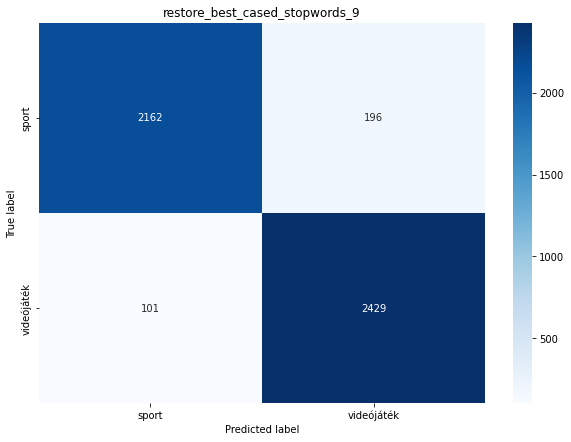

Iteration  10
Epoch 1/10
2444/2444 [==============================] - 1916s 784ms/step - loss: 0.1022 - accuracy: 0.9585 - val_loss: 0.1855 - val_accuracy: 0.9413
Epoch 2/10
2444/2444 [==============================] - 1911s 782ms/step - loss: 0.0980 - accuracy: 0.9618 - val_loss: 0.3130 - val_accuracy: 0.8695
Epoch 3/10
2444/2444 [==============================] - 1913s 782ms/step - loss: 0.0884 - accuracy: 0.9651 - val_loss: 0.2174 - val_accuracy: 0.9396
Restoring model weights from the end of the best epoch.
Epoch 00003: early stopping
3
Epoch 1  : loss: 0.1022 - accuracy: 0.9585 - val_loss: 0.1855 - val_accuracy: 0.9413
Epoch 2  : loss: 0.0980 - accuracy: 0.9618 - val_loss: 0.3130 - val_accuracy: 0.8695
Epoch 3  : loss: 0.0884 - accuracy: 0.9651 - val_loss: 0.2174 - val_accuracy: 0.9396
153/153 [==============================] - 78s 511ms/step - loss: 0.1858 - accuracy: 0.9450
Classification report:
              precision    recall  f1-score   support

           0       0.96     

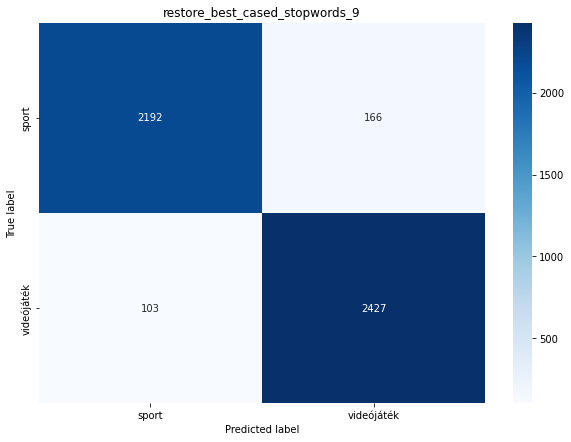

Iteration  11
Epoch 1/10
2444/2444 [==============================] - 1939s 793ms/step - loss: 0.0881 - accuracy: 0.9653 - val_loss: 0.2927 - val_accuracy: 0.9411

Epoch 00001: saving model to checkpoints/sport/restore_best_cased_stopwords_9\cp.ckpt
Epoch 2/10
 656/2444 [=======>......................] - ETA: 24:39 - loss: 0.0771 - accuracy: 0.9701

In [ ]:
for i in range(9, 12):
  ITER = str(i)
  print("Iteration ", ITER)
  history, result, predict = fit_model()
  evaluate(predict, result, y_test_labels)

In [ ]:
import winsound
#for i in range(2, 12):
#    winsound.Beep(100 + i * 100, 400)
